In [1]:
# Goal: to make a volcano plot of differentially-bound 
# BRD4 peaks in stem-like and differentiated-like K562 cells
import anndata as ad
import copy
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pybedtools import BedTool
import scanpy.api as sc
import scipy.stats as stats
from statsmodels.stats import multitest

In [2]:
# Initial setup
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi = 150,
                     dpi_save = 300,
                     vector_friendly = True,
                     transparent = True,
                     format = "pdf")
sc.logging.print_versions()
out_dir = "../output_and_analysis/reanalysis/"

scanpy==1.3.7 anndata==0.6.17 numpy==1.17.2 scipy==1.2.1 pandas==0.23.4 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 


In [3]:
# Read files
peaks = BedTool(out_dir + "K562-HyPB_scCC_final_p9.bed")
stem_hops = BedTool(out_dir + "K562-HyPB_scCC_final_stem.ccf")
diff_hops = BedTool(out_dir + "K562-HyPB_scCC_final_diff.ccf")

In [4]:
# Calculate intersections
data = peaks.intersect(stem_hops, c = True).intersect(diff_hops, c = True).to_dataframe()
data.columns = ["chrom", "start", "end", "stem_hops", "diff_hops"]
data["total_hops"] = data["stem_hops"] + data["diff_hops"]

In [5]:
# Create a file of peaks where there are at least 20 hops between stem and diff
new_peaks = data[data["total_hops"] > 20][["chrom", "start", "end"]]
new_peaks.to_csv(out_dir + "K562-HyPB_scCC_final_p9_gt20.bed", sep='\t', index=False, header=None)

In [6]:
# Repeat analysis with new peaks, using 5% FDR and writing intermediate files
peaks_gt20 = BedTool(out_dir + "K562-HyPB_scCC_final_p9_gt20.bed")
stem_hops = BedTool(out_dir + "K562-HyPB_scCC_final_stem.ccf")
diff_hops = BedTool(out_dir + "K562-HyPB_scCC_final_diff.ccf")
# Calculate intersections
data_gt20 = peaks_gt20.intersect(stem_hops, c = True).intersect(diff_hops, c = True).to_dataframe()
data_gt20.columns = ["chrom", "start", "end", "stem_hops", "diff_hops"]
# Normalize observed insertions by library size after adding pseudocount of 1
data_gt20["norm_stem_hops"] = (data_gt20["stem_hops"] + 1) / ((len(stem_hops) + 1) / 10**6)
data_gt20["norm_diff_hops"] = (data_gt20["diff_hops"] + 1) / ((len(diff_hops) + 1) / 10**6)
# Calculate normalized log2FC
data_gt20["norm_log2FC"] = np.log2(data_gt20["norm_diff_hops"] / data_gt20["norm_stem_hops"])
# Summary statistics
np.mean(data_gt20["norm_log2FC"]), np.var(data_gt20["norm_log2FC"])

(-0.06355966236473848, 0.21804513748513996)

In [7]:
# Open intermediate files from peak calling
stem_gt20_intermediate = pd.read_csv(out_dir + "K562-HyPB_scCC_final_stem_a10_fdr_gt20_intermediate.csv")
diff_gt20_intermediate = pd.read_csv(out_dir + "K562-HyPB_scCC_final_diff_a10_fdr_gt20_intermediate.csv")
# Add the p-value and rejected columns from the intermediate files to data
data_gt20["stem pValue"] = stem_gt20_intermediate["pValue"]
data_gt20["diff pValue"] = diff_gt20_intermediate["pValue"]
data_gt20["rejected"] = stem_gt20_intermediate["rejected"] | diff_gt20_intermediate["rejected"]
# Find the minimum p-value between both comparisons
data_gt20["pValue"] = data_gt20[["stem pValue", "diff pValue"]].min(axis = 1)

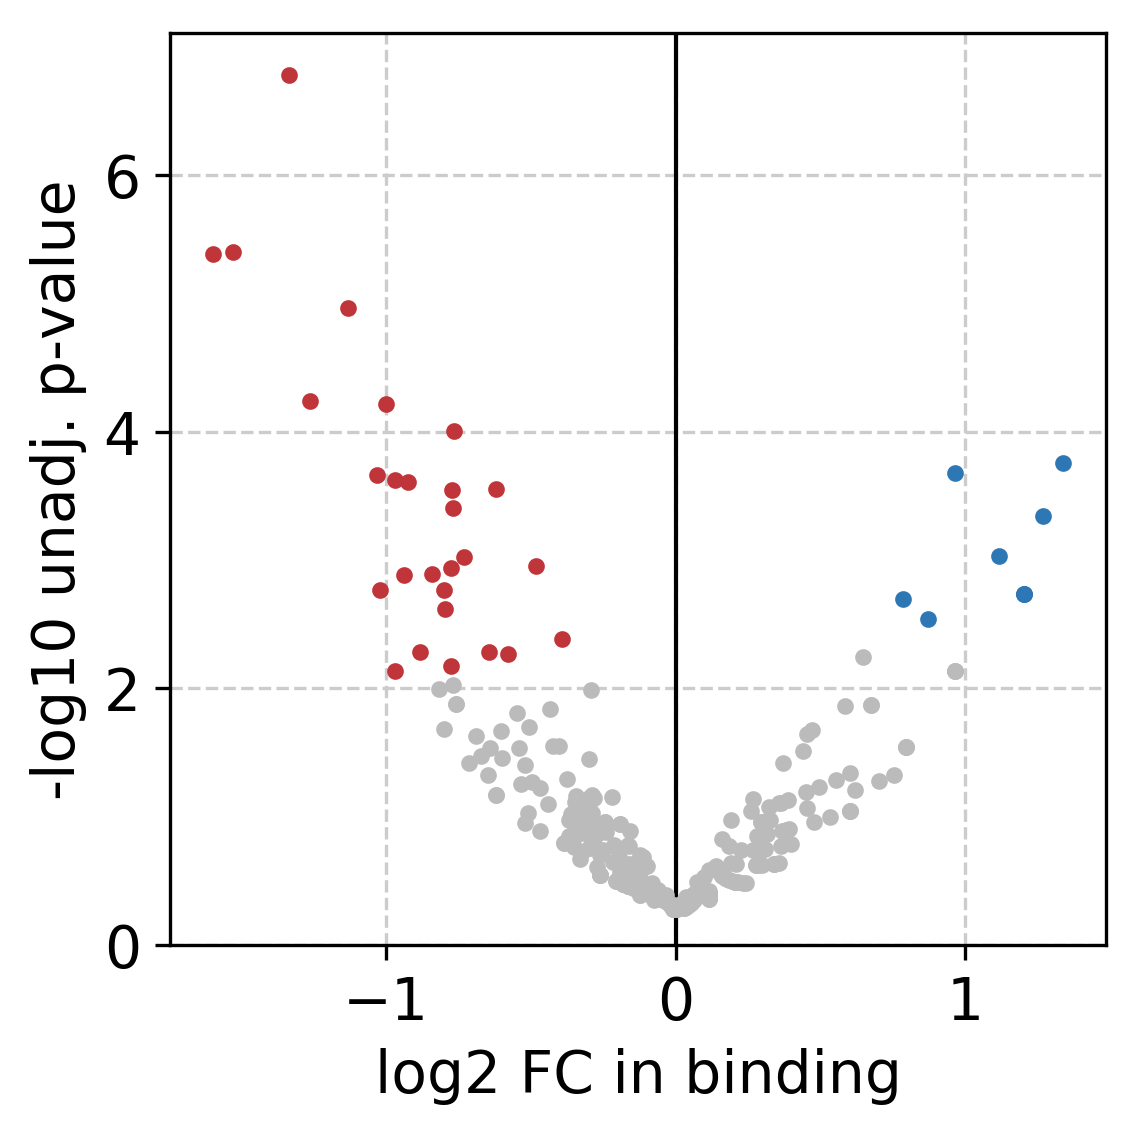

In [8]:
null_gt20 = data_gt20[data_gt20["rejected"] == False]
rejected_gt20 = data_gt20[data_gt20["rejected"]]
stem_rejected_gt20 = rejected_gt20[rejected_gt20["norm_log2FC"] < 0]
diff_rejected_gt20 = rejected_gt20[rejected_gt20["norm_log2FC"] > 0]
plt.axvline(x = 0, color = 'k', linewidth = 1)
plt.plot(null_gt20["norm_log2FC"], -np.log10(null_gt20["pValue"]), 'o', color = "#BBBBBB", markersize = 3)
plt.plot(stem_rejected_gt20["norm_log2FC"], -np.log10(stem_rejected_gt20["pValue"]), 'o', color = "#C03539", markersize = 3)
plt.plot(diff_rejected_gt20["norm_log2FC"], -np.log10(diff_rejected_gt20["pValue"]), 'o', color = "#2D77B5", markersize = 3)
plt.xlabel("log2 FC in binding")
plt.ylabel("-log10 unadj. p-value")
plt.grid(b = True, which = "major", linestyle = '--')
plt.ylim(bottom = 0)
plt.savefig(out_dir + "K562-HyPB_scCC_final_volcano.pdf", transparent=True, bbox_inches="tight")

In [9]:
print(len(data_gt20[data_gt20["norm_log2FC"] < 0]), len(data_gt20[data_gt20["norm_log2FC"] > 0]))
stats.binom.sf(len(data_gt20[data_gt20["norm_log2FC"] < 0]), len(data_gt20[data_gt20["norm_log2FC"] < 0]) + len(data_gt20[data_gt20["norm_log2FC"] > 0]), 0.5)

170 131


0.010490330846881316

In [10]:
# Get all candidate hits
data_gt20[data_gt20["rejected"]]

,chrom,start,end,stem_hops,diff_hops,norm_stem_hops,norm_diff_hops,norm_log2FC,stem pValue,diff pValue,rejected,pValue
21,chr1,120231799,120282967,37,15,911.096193,415.768001,-1.131825,1.094351e-05,0.999891,True,1.094351e-05
22,chr1,120615420,121378757,93,61,2253.764266,1611.101006,-0.484290,1.114915e-03,0.997805,True,1.114915e-03
23,chr1,143952006,144051401,21,10,527.476743,285.840501,-0.883897,5.221967e-03,0.991182,True,5.221967e-03
37,chr1,207309214,207521099,32,16,791.215115,441.753502,-0.840828,1.292277e-03,0.997024,True,1.292277e-03
39,chr1,211155360,211372595,21,9,527.476743,259.855001,-1.021401,1.720031e-03,0.995992,True,1.720031e-03
42,chr1,223934001,224542635,19,35,479.524312,935.478003,0.964100,9.996868e-01,0.000208,True,2.077809e-04
47,chr1,246141629,246192692,16,7,407.595665,207.884001,-0.971360,7.262645e-03,0.988480,True,7.262645e-03
52,chr10,22311416,22393617,25,13,623.381605,363.797001,-0.776982,6.643943e-03,0.989634,True,6.643943e-03
59,chr10,63224460,63722259,38,22,935.072408,597.666502,-0.645737,5.168955e-03,0.991761,True,5.168955e-03
61,chr10,72089488,74244405,103,72,2493.526422,1896.941507,-0.394512,4.100745e-03,0.993676,True,4.100745e-03


In [11]:
data_gt20[data_gt20["rejected"]].to_csv(out_dir + "K562-HyPB_scCC_final_a10_fdr_stem_diff.csv", sep=',', index=False, header=None)

In [12]:
# Visualize gene expression differences between stem and diff cells
out_stem = "../../GTAC_273N-scCC-InVitro-cDNA/output_and_analysis/reanalysis/K562-HyPB"
k_file = out_stem + ".h5ad"
k_data = sc.read(k_file)
# k_data.obs["state"]
stem_barcodes = [_.strip() for _ in open("../../GTAC_273N-scCC-InVitro-cDNA/output_and_analysis/reanalysis/K562-HyPB_stem_barcodes.csv")]
diff_barcodes = [_.strip() for _ in open("../../GTAC_273N-scCC-InVitro-cDNA/output_and_analysis/reanalysis/K562-HyPB_diff_barcodes.csv")]
stem_data = k_data[stem_barcodes]
stem_data.obs["Category"] = "Stem"
diff_data = k_data[diff_barcodes]
diff_data.obs["Category"] = "Diff"
categorical = ad.AnnData.concatenate(stem_data, diff_data, index_unique = None)

... storing 'Category' as categorical
... storing 'state' as categorical


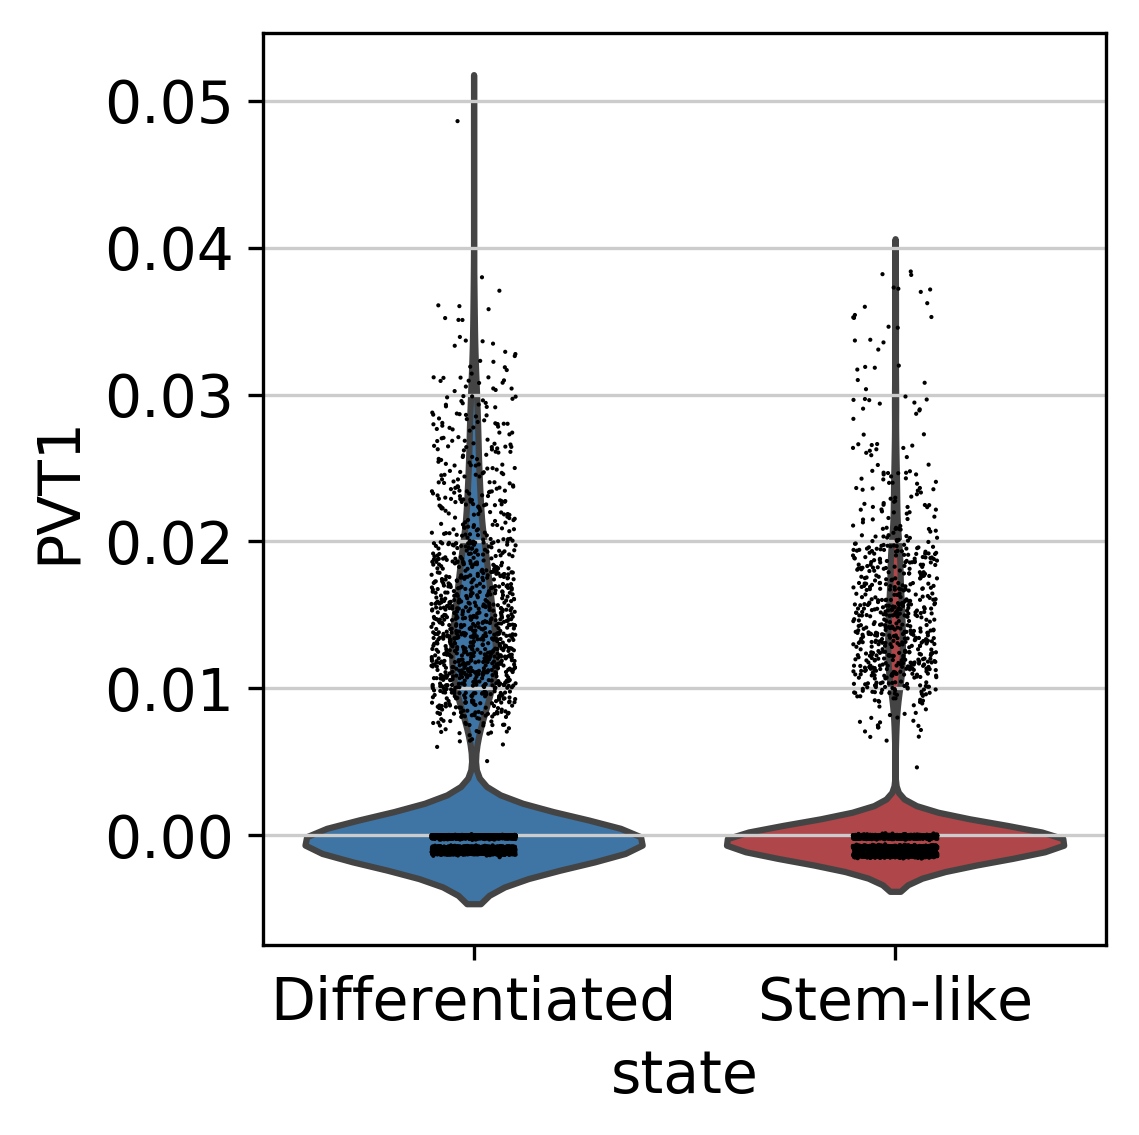

Ks_2sampResult(statistic=0.1545944749808369, pvalue=4.145385766702696e-46)

In [13]:
# Violin plot for a given gene
gene = "PVT1"
sc.pl.violin(categorical, gene, groupby = "state", palette = {"Stem-like": "#C03539", "Differentiated": "#2D77B5"}, alpha = 0.5)
stats.ks_2samp(stem_data[:, [gene]].X, diff_data[:, [gene]].X)

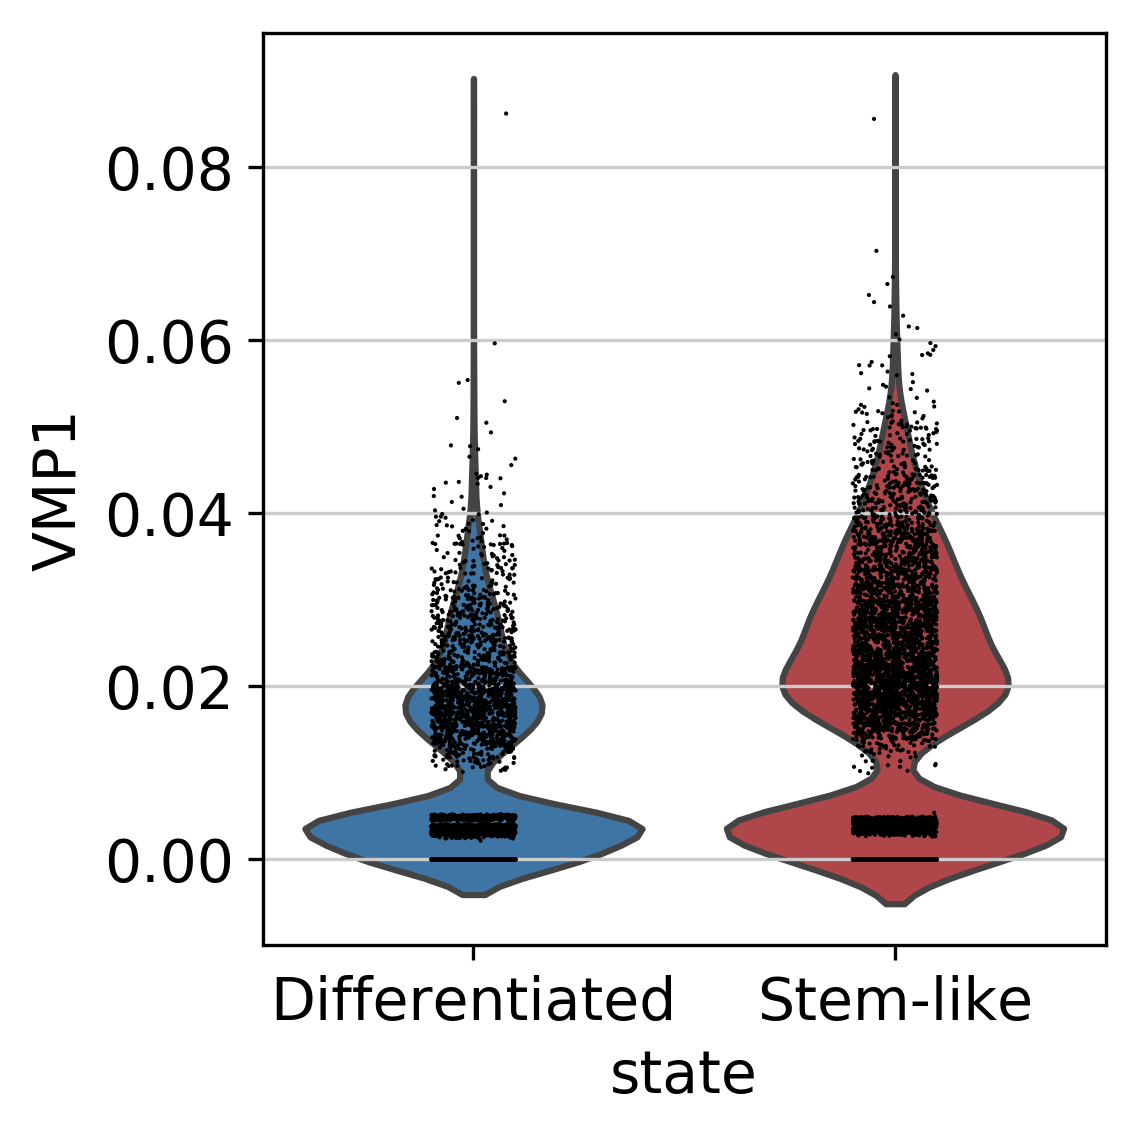

Ks_2sampResult(statistic=0.28306673412941563, pvalue=1.3798349479849202e-153)

In [27]:
# Violin plot for a given gene
gene = "VMP1"
sc.pl.violin(categorical, gene, groupby = "state", palette = {"Stem-like": "#C03539", "Differentiated": "#2D77B5"}, alpha = 0.5)
stats.ks_2samp(stem_data[:, [gene]].X, diff_data[:, [gene]].X)